# Setup

In [1]:
!pip install pybiomart

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.7/70.7 kB 5.3 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')
project_path = '/content/drive/MyDrive/systems_genetics/'

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from pybiomart import Server
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import average_precision_score
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge


import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import numpy as np
#from model import HPOClassifier
#from utils import split_data, plot_training_curves, plot_roc_curves, plot_prediction_distribution, plot_top_k_accuracy, plot_per_class_performance

from sklearn.metrics import roc_auc_score, average_precision_score

# Load OMICS Embeddings and HPO annotations

In [4]:
# Load Embeddings (X)
# index = ensemble ID
X_log = pd.read_csv(f'{project_path}data/omics_embedding/OMICS_EMB_log_sigma.tsv', sep="\t" ,index_col=0)
X_org = pd.read_csv(f'{project_path}data/omics_embedding/OMICS_EMB.tsv', sep="\t" ,index_col=0)

# Load HPO Annotations (Raw Data)

phenotype = pd.read_csv(f'{project_path}data/hpo/phenotype.hpoa', sep='\t', comment='#', header=None,
                     names=['gene_id', 'gene_symbol', 'hpo_name', 'hpo_id', 'freq', 'disease', 'etc'])

hpo_df = pd.read_csv(f'{project_path}data/hpo/genes_to_phenotype.txt', sep='\t', comment='#')

/tmp/ipython-input-2946930613.py:8: DtypeWarning: Columns (2,6,8,9) have mixed types. Specify dtype option on import or set low_memory=False.
  phenotype = pd.read_csv(f'{project_path}data/hpo/phenotype.hpoa', sep='\t', comment='#', header=None,


Ensemble ID <-> NCBI mapping

In [5]:
# get ensembl to ncbi mapping

server = Server(host='http://www.ensembl.org')
dataset = server.marts['ENSEMBL_MART_ENSEMBL'].datasets['hsapiens_gene_ensembl']


print("Querying BioMart...")
mapping_df = dataset.query(attributes=['ensembl_gene_id', 'entrezgene_id'])


print("Columns returned by BioMart:", mapping_df.columns.tolist())


mapping_df.rename(columns={
    'Gene stable ID': 'ensembl_id',
    'NCBI gene (formerly Entrezgene) ID': 'ncbi_id'
}, inplace=True)


mapping_df = mapping_df.dropna(subset=['ncbi_id'])

mapping_df['ncbi_id'] = mapping_df['ncbi_id'].astype(int).astype(str)

print(mapping_df.head())

Querying BioMart...
Columns returned by BioMart: ['Gene stable ID', 'NCBI gene (formerly Entrezgene) ID']
         ensembl_id    ncbi_id
5   ENSG00000198888       4535
9   ENSG00000198763       4536
15  ENSG00000198804       4512
16  ENSG00000210151  113219467
18  ENSG00000198712       4513


In [6]:
hpo_df['ncbi_gene_id'] = hpo_df['ncbi_gene_id'].astype(str)

# attach Ensembl IDs to HPO data
hpo_mapped = hpo_df.merge(mapping_df, left_on='ncbi_gene_id', right_on='ncbi_id', how='inner')

print(f"Original annotations: {len(hpo_df)}")
print(f"Mapped annotations:   {len(hpo_mapped)}")

Original annotations: 320212
Mapped annotations:   352989


In [7]:
# how many unique Ensembl IDs are associated with each HPO ID
term_counts = hpo_mapped.groupby('hpo_id')['ensembl_id'].nunique()

# at least 20 genes annotated (like in paper)
min_genes = 20
valid_terms = term_counts[term_counts >= min_genes].index


hpo_filtered = hpo_mapped[hpo_mapped['hpo_id'].isin(valid_terms)]

print(f"Filtering criteria: >= {min_genes} genes per term")
print(f"Number of HPO terms remaining: {len(valid_terms)}")


# rows = ensembl IDs, columns = HPO IDs
Y_full = pd.crosstab(hpo_filtered['ensembl_id'], hpo_filtered['hpo_id'])

Y_full = (Y_full > 0).astype(int)

print(f"Y Matrix Shape: {Y_full.shape} (Genes x {Y_full.shape[1]} HPO Terms)")

Filtering criteria: >= 20 genes per term
Number of HPO terms remaining: 2531
Y Matrix Shape: (5752, 2531) (Genes x 2531 HPO Terms)


In [8]:
# find genes present in both datasets
common_genes_omics = X_log.index.intersection(Y_full.index)

X_aligned = X_log.loc[common_genes_omics]
Y_aligned = Y_full.loc[common_genes_omics]

print(f"Final Training Data (transformed): {len(common_genes_omics)} genes")

# original embeddings
common_genes_org = X_org.index.intersection(Y_full.index)


X_aligned_org = X_org.loc[common_genes_org]
Y_aligned = Y_full.loc[common_genes_org]

print(f"Final Training Data (original): {len(common_genes_org)} genes")

Final Training Data (transformed): 5079 genes
Final Training Data (original): 5079 genes


In [9]:
# Save the index (Ensembl IDs) to a simple text file
X_aligned.index.to_series().to_csv("common_genes.csv", index=False, header=False)

# Load New Embeddings from `.pkl`

In [47]:
def load_embedding_from_pickle(file_path, index_name):
    with open(file_path, 'rb') as f:
        embedding_dict = pickle.load(f)

    emb_name = file_path.split('/')[-1].split('.')[0]

    embeddings_df = pd.DataFrame.from_dict(embedding_dict, orient='index')
    embeddings_df.index.name = index_name

    print(f"Loaded {emb_name} for {len(embeddings_df)} genes.")
    print(f"First 5 rows of {emb_name}:")
    display(embeddings_df.head())

    if index_name != 'ensemble_id':
      from pybiomart import Server

      server = Server(host='http://www.ensembl.org')
      dataset = server.marts['ENSEMBL_MART_ENSEMBL'].datasets['hsapiens_gene_ensembl']

      print("Querying BioMart for Gene Symbol to Ensembl ID mapping...")
      gene_symbol_mapping_df = dataset.query(attributes=['ensembl_gene_id', 'hgnc_symbol'])

      # Rename columns for clarity
      gene_symbol_mapping_df.rename(columns={
          'Gene stable ID': 'ensembl_id',
          'HGNC symbol': 'gene_symbol'
      }, inplace=True)

      # Drop rows where either ID is missing
      gene_symbol_mapping_df = gene_symbol_mapping_df.dropna(subset=['ensembl_id', 'gene_symbol'])

      print(f"Found {len(gene_symbol_mapping_df)} gene symbol to Ensembl ID mappings.")
      print(gene_symbol_mapping_df.head())

      # Merge new embeddings with the gene symbol to Ensembl ID mapping
      merged_embeddings = embeddings_df.merge(
      gene_symbol_mapping_df,
      left_index=True,  # Use gene_symbol from new_embeddings_df as key
      right_on='gene_symbol',
      how='inner')       # Only keep genes that have both symbol and Ensembl ID

      merged_embeddings = merged_embeddings.set_index('ensembl_id')

      # Drop the 'gene_symbol' column as it's no longer needed as an explicit column
      merged_embeddings = merged_embeddings.drop(columns=['gene_symbol'])

      embeddings_df = merged_embeddings


    return embeddings_df


In [45]:
import pickle
borzoi_embeddings_path = f'{project_path}borzoi_embeddings.pkl'
borzoi_emb = load_embedding_from_pickle(borzoi_embeddings_path, 'ensemble_id')

common_genes_borzoi = borzoi_emb.index.intersection(Y_aligned.index)

X_aligned_borzoi = borzoi_emb.loc[common_genes_borzoi]
Y_aligned_borzoi = Y_aligned.loc[common_genes_borzoi]

print(f"Borzoi aligned: {len(common_genes_borzoi)} genes.")
print(f"Shape of X_new_aligned: {X_aligned_borzoi.shape}")
print(f"Shape of Y_aligned_new_embeddings: {Y_aligned_borzoi.shape}")



Loaded borzoi_embeddings for 4381 genes.
First 5 rows of borzoi_embeddings:


/usr/local/lib/python3.12/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
ensemble_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000154646,-8.523438,-5.265625,3.667969,-8.460938,-7.363281,-4.054688,0.739258,0.561035,-8.953125,2.734375,...,-2.429688,0.178833,-2.789062,4.726562,-0.429688,-2.316406,5.855469,1.398438,8.734375,5.648438
ENSG00000183421,15.656250,0.661133,9.781250,-3.421875,-7.437500,-3.384766,0.277100,20.359375,12.820312,-0.155762,...,-11.820312,0.293945,1.474609,1.707031,5.644531,-11.812500,-1.220703,-2.443359,-0.915527,-7.289062
ENSG00000160226,-3.007812,-12.015625,-1.060547,-5.062500,-24.687500,-5.277344,6.214844,-6.535156,2.728516,-0.391846,...,1.583008,6.804688,-1.872070,0.159058,-15.453125,-1.814453,-6.019531,3.568359,-0.099915,-3.939453
ENSG00000160294,-3.666016,-7.648438,-4.214844,-4.156250,-2.410156,-2.945312,6.738281,-2.396484,-7.976562,-2.132812,...,-2.031250,-1.271484,-4.589844,-6.222656,-11.625000,-5.121094,2.488281,-10.062500,-3.541016,1.997070
ENSG00000150893,3.656250,9.773438,-7.375000,5.386719,-1.567383,3.794922,-6.195312,20.703125,-0.561523,3.062500,...,-1.026367,-6.605469,-6.687500,2.861328,-0.210938,-8.531250,-0.675781,2.035156,4.351562,1.711914


Borzoi aligned: 4381 genes.
Shape of X_new_aligned: (4381, 1536)
Shape of Y_aligned_new_embeddings: (4381, 2531)


In [48]:
import pickle
esmc_300_embeddings_path = f'{project_path}gene2emb_esm_c_esmc_300m.pkl'
esmc_300_emb = load_embedding_from_pickle(esmc_300_embeddings_path, 'gene_symbol')
display(esmc_300_emb.head())
common_genes_esmc_300 = esmc_300_emb.index.intersection(Y_aligned.index)

X_aligned_esmc_300 = esmc_300_emb.loc[common_genes_esmc_300]
Y_aligned_esmc_300 = Y_aligned.loc[common_genes_esmc_300]

print(f"ESM C (300M) aligned: {len(common_genes_esmc_300)} genes.")
print(f"Shape of X_new_aligned: {X_aligned_esmc_300.shape}")
print(f"Shape of Y_aligned_new_embeddings: {Y_aligned_esmc_300.shape}")

Loaded gene2emb_esm_c_esmc_300m for 5067 genes.
First 5 rows of gene2emb_esm_c_esmc_300m:


,0,1,2,3,4,5,6,7,8,9,...,950,951,952,953,954,955,956,957,958,959
gene_symbol,,,,,,,,,,,,,,,,,,,,,
STX16,-0.000883,0.011987,-0.000450,-0.018524,-0.001403,0.001757,0.000368,-0.009437,0.006797,0.008638,...,0.018062,-0.002429,0.020643,0.004454,-0.000668,-0.011259,-0.002736,0.002757,-0.031023,-0.008770
CLDN9,-0.013751,-0.005688,0.007323,-0.002947,0.015149,0.000953,0.026441,0.003225,0.005538,0.003512,...,0.009119,-0.006726,0.037786,0.009632,-0.015575,-0.002556,0.009012,-0.015585,-0.033258,-0.025737
ASXL2,-0.003200,-0.004638,0.005888,0.021406,-0.000470,0.010202,-0.003152,-0.001364,0.002336,-0.000177,...,0.038886,-0.011180,0.031981,-0.013964,-0.006503,-0.032290,0.016037,-0.013212,-0.049497,-0.005311
PPP2CA,-0.006722,-0.010155,0.010496,0.000401,0.009489,0.014369,0.005302,-0.002363,0.017315,0.018300,...,0.023755,-0.017741,0.039909,0.001410,-0.011077,-0.010628,0.018517,0.011544,-0.016754,-0.013687
PYCR2,-0.007521,-0.008862,-0.005672,0.004089,0.007890,0.005489,-0.011041,-0.004608,-0.002872,0.012073,...,0.016441,-0.004631,0.030577,0.010607,0.004080,-0.021411,0.007064,0.002257,-0.016951,-0.023084


Querying BioMart for Gene Symbol to Ensembl ID mapping...
Found 46922 gene symbol to Ensembl ID mappings.
        ensembl_id gene_symbol
0  ENSG00000210049       MT-TF
1  ENSG00000211459     MT-RNR1
2  ENSG00000210077       MT-TV
3  ENSG00000210082     MT-RNR2
4  ENSG00000209082      MT-TL1


,0,1,2,3,4,5,6,7,8,9,...,950,951,952,953,954,955,956,957,958,959
ensembl_id,,,,,,,,,,,,,,,,,,,,,
ENSG00000124222,-0.000883,0.011987,-0.000450,-0.018524,-0.001403,0.001757,0.000368,-0.009437,0.006797,0.008638,...,0.018062,-0.002429,0.020643,0.004454,-0.000668,-0.011259,-0.002736,0.002757,-0.031023,-0.008770
ENSG00000213937,-0.013751,-0.005688,0.007323,-0.002947,0.015149,0.000953,0.026441,0.003225,0.005538,0.003512,...,0.009119,-0.006726,0.037786,0.009632,-0.015575,-0.002556,0.009012,-0.015585,-0.033258,-0.025737
ENSG00000143970,-0.003200,-0.004638,0.005888,0.021406,-0.000470,0.010202,-0.003152,-0.001364,0.002336,-0.000177,...,0.038886,-0.011180,0.031981,-0.013964,-0.006503,-0.032290,0.016037,-0.013212,-0.049497,-0.005311
ENSG00000113575,-0.006722,-0.010155,0.010496,0.000401,0.009489,0.014369,0.005302,-0.002363,0.017315,0.018300,...,0.023755,-0.017741,0.039909,0.001410,-0.011077,-0.010628,0.018517,0.011544,-0.016754,-0.013687
ENSG00000143811,-0.007521,-0.008862,-0.005672,0.004089,0.007890,0.005489,-0.011041,-0.004608,-0.002872,0.012073,...,0.016441,-0.004631,0.030577,0.010607,0.004080,-0.021411,0.007064,0.002257,-0.016951,-0.023084


ESM C (300M) aligned: 5063 genes.
Shape of X_new_aligned: (5063, 960)
Shape of Y_aligned_new_embeddings: (5063, 2531)


Load train/val/test genes

In [26]:
train_genes = pd.read_csv(f'{project_path}data/splits/train_genes.tsv', header=None)[0].astype(str).tolist()
val_genes = pd.read_csv(f'{project_path}data/splits/validation_genes.tsv', header=None)[0].astype(str).tolist()
test_genes = pd.read_csv(f'{project_path}data/splits/test_genes.tsv', header=None)[0].astype(str).tolist()

# Ridge Regression Results

In simple terms, Ridge Regression is Linear Regression with a penalty.

- The Core Idea: Like standard regression, it tries to find a linear equation (a weighted sum of your omics features) that best predicts the target (whether a gene has a specific HPO term).

- The Problem it Solves: Biological data (like gene expression) is often "multicollinear"—meaning many features are correlated (e.g., if Gene A is expressed, Gene B is often expressed too). Standard regression fails or overfits badly on this.

- The "Ridge" Solution: It adds a "penalty" (L2 regularization) to the loss function that shrinks the coefficients of the model towards zero. This prevents any single feature from dominating the prediction just because of noise, making the model more generalizable to new genes.

Perform Ridge Regression with fixed train/val/test split

In [25]:
def split_data(X, Y, train_genes_list, val_genes_list, test_genes_list):
    """
    Splits X and Y into Train, Val, Test sets based on provided gene lists.
    """

    print(f"Loaded Genes -> Train: {len(train_genes_list)}, Val: {len(val_genes_list)}, Test: {len(test_genes_list)}")

    train_idx = X.index.intersection(train_genes_list)
    val_idx   = X.index.intersection(val_genes_list)
    test_idx  = X.index.intersection(test_genes_list)

    X_train, Y_train = X.loc[train_idx], Y.loc[train_idx]
    X_val,   Y_val   = X.loc[val_idx],   Y.loc[val_idx]
    X_test,  Y_test  = X.loc[test_idx],  Y.loc[test_idx]


    print(f"Effective Split -> Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

In [27]:
def predict_hpo_terms_base(model, X, Y, train_genes, val_genes, test_genes):
    """
    Trains on defined Train set, evaluates on Test set.
    Validation set is loaded but typically reserved for hyperparam tuning
    (or merged into Train if no tuning is performed).
    """

    X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data(X, Y, train_genes, val_genes, test_genes)

    # 4. OPTIONAL: Merge Train + Val?
    # If you are NOT tuning hyperparameters (grid search) inside this function,
    # it is often best practice to train on Train + Val to maximize data.
    # Uncomment the next two lines to merge them:
    X_train = pd.concat([X_train, X_val])
    Y_train = pd.concat([Y_train, Y_val])

    # train
    print("Fitting model...")
    model.fit(X_train, Y_train)


    print("Predicting on Test set...")
    Y_pred = model.predict(X_test)

    # evaluate
    results = {}

    for i, hpo_term in enumerate(Y.columns):
        y_true = Y_test.iloc[:, i]
        y_score = Y_pred[:, i]

        if np.sum(y_true) > 0:
            score = average_precision_score(y_true, y_score)
            results[hpo_term] = score
        else:
            results[hpo_term] = np.nan

    return results

### OMICS embeddings

In [28]:
results_base = predict_hpo_terms_base(Ridge(alpha=1.0),X_aligned, Y_aligned, train_genes, val_genes,test_genes)

valid_scores = [s for s in results_base.values() if not np.isnan(s)]
print(f"Mean Test AUPRC: {np.mean(valid_scores):.4f}")

Loaded Genes -> Train: 4064, Val: 509, Test: 509
Effective Split -> Train: 4063, Val: 508, Test: 508
Fitting model...
Predicting on Test set...
Mean Test AUPRC: 0.1112


In [29]:
results_base_org = predict_hpo_terms_base(Ridge(alpha=1.0),X_aligned, Y_aligned, train_genes, val_genes,test_genes)

valid_scores_org = [s for s in results_base_org.values() if not np.isnan(s)]
print(f"Mean Test AUPRC: {np.mean(valid_scores_org):.4f}")

Loaded Genes -> Train: 4064, Val: 509, Test: 509
Effective Split -> Train: 4063, Val: 508, Test: 508
Fitting model...
Predicting on Test set...
Mean Test AUPRC: 0.1112


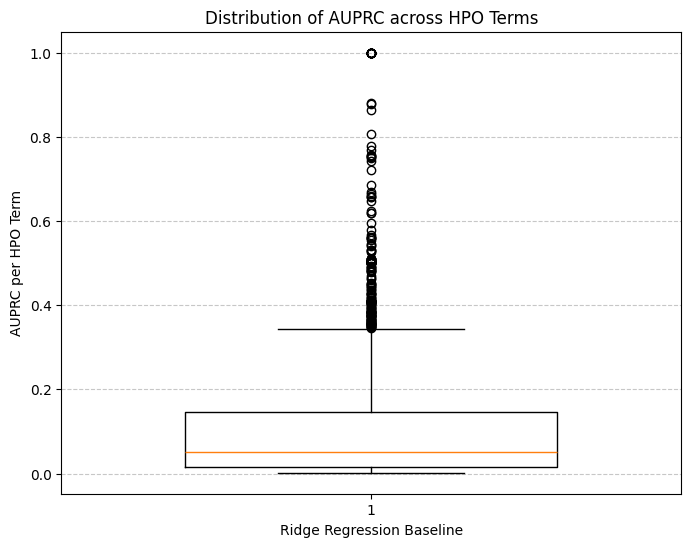

In [30]:
# box plot with results
plt.figure(figsize=(8, 6))
plt.boxplot(valid_scores, positions=[1], widths=0.6)
plt.xlabel('Ridge Regression Baseline - OMICS embedding')
plt.ylabel('AUPRC per HPO Term')
plt.title('Distribution of AUPRC across HPO Terms')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Borzoi embedding

In [31]:
results_borzoi = predict_hpo_terms_base(Ridge(alpha=1.0), X_aligned_borzoi, Y_aligned_borzoi,train_genes, val_genes,test_genes)

scores_results_borzoi = [s for s in results_borzoi.values() if not np.isnan(s)]
print(f"Mean Test AUPRC: {np.mean(scores_results_borzoi):.4f}")


Loaded Genes -> Train: 4064, Val: 509, Test: 509
Effective Split -> Train: 3489, Val: 451, Test: 441
Fitting model...
Predicting on Test set...
Mean Test AUPRC: 0.0773


### ESM C (300M)

In [56]:
results_esmc_300 = predict_hpo_terms_base(Ridge(alpha=1.0), X_aligned_esmc_300, Y_aligned_esmc_300,train_genes, val_genes,test_genes)

scores_results_esmc_300 = [s for s in results_esmc_300.values() if not np.isnan(s)]
print(f"Mean Test AUPRC: {np.mean(scores_results_esmc_300):.4f}")

Loaded Genes -> Train: 4064, Val: 509, Test: 509
Effective Split -> Train: 4051, Val: 505, Test: 507
Fitting model...
Predicting on Test set...
Mean Test AUPRC: 0.0956


# Integrating Mouse Orthology

In [32]:
# load mouse phenotype data
url = "https://ftp.ebi.ac.uk/pub/databases/impc/all-data-releases/release-23.0/results/phenotypeHitsPerGene.csv.gz"
print("Loading IMPC data... ")

impc_df = pd.read_csv(url, compression='gzip')

# separator '::'
impc_df['phenotype_list'] = impc_df['Phenotype Hits'].str.split('::')

# explode: turns 1 row with 3 hits into 3 rows with 1 hit each
impc_long = impc_df.explode('phenotype_list')

impc_long = impc_long.rename(columns={'phenotype_list': 'mp_term'})

# key: MGI Gene Id, feature: mp_term
mouse_data = impc_long[['MGI Gene Id', 'mp_term']].drop_duplicates()

print(f"Processed {len(mouse_data)} mouse gene-phenotype associations.")
print(mouse_data.head())

Loading IMPC data... 
Processed 43539 mouse gene-phenotype associations.
  MGI Gene Id                                           mp_term
0   MGI:99403           abnormal retina blood vessel morphology
0   MGI:99403  increased circulating alkaline phosphatase level
0   MGI:99403       increased fasting circulating glucose level
0   MGI:99403                               convulsive seizures
0   MGI:99403               decreased circulating glucose level


In [33]:
from pybiomart import Server


server = Server(host='http://www.ensembl.org')
dataset = server.marts['ENSEMBL_MART_ENSEMBL'].datasets['mmusculus_gene_ensembl']

print("Fetching Orthology map...")

# MGI ID <-> Mouse Ensembl ID
mgi_map = dataset.query(attributes=['mgi_id', 'ensembl_gene_id'])
mgi_map.columns = ['mgi_id', 'mouse_ensembl_id']

# Mouse Ensembl ID <-> Human Ensembl ID
homolog_map = dataset.query(attributes=['ensembl_gene_id', 'hsapiens_homolog_ensembl_gene'])
homolog_map.columns = ['mouse_ensembl_id', 'human_ensembl_id']

# Merge to link MGI -> Human
ortho_map = pd.merge(mgi_map, homolog_map, on='mouse_ensembl_id')
ortho_map = ortho_map[['mgi_id', 'human_ensembl_id']].dropna()

print(f"Mapped {len(ortho_map)} MGI IDs to Human Ensembl IDs.")

Fetching Orthology map...
Mapped 24879 MGI IDs to Human Ensembl IDs.


Create binary Mouse Feature Matrix

In [34]:
# mouse_data: ['MGI Gene Id', 'mp_term']
# ortho_final: ['mgi_id', 'human_ensembl_id']
merged_mouse = ortho_map.merge(
    mouse_data,
    left_on='mgi_id',
    right_on='MGI Gene Id',
    how='inner'
)

# Binary Mouse Feature Matrix
# Rows = Human Ensembl IDs, Cols = Mouse Phenotype Terms
X_mouse_feats = pd.crosstab(merged_mouse['human_ensembl_id'], merged_mouse['mp_term'])
X_mouse_feats = (X_mouse_feats > 0).astype(int)

print(f"Mouse Feature Matrix created: {X_mouse_feats.shape}")


# reindex(..., fill_value=0) to ensure genes with no mouse data get 0s
X_mouse_aligned = X_mouse_feats.reindex(X_aligned.index, fill_value=0)

# concatenate: [Human Omics Features | Mouse Phenotype Features]
X_augmented = pd.concat([X_aligned, X_mouse_aligned], axis=1)

print(f"Original Features: {X_aligned.shape[1]}")
print(f"Augmented Features: {X_augmented.shape[1]}")

# ridge regression
print("Starting Augmented Benchmark...")
aug_results = predict_hpo_terms_base(Ridge(alpha=1.0),X_augmented, Y_aligned, train_genes, val_genes,test_genes)
aug_scores = [s for s in aug_results.values() if not np.isnan(s)]
print(f"Mean Test AUPRC: {np.mean(aug_scores):.4f}")

Mouse Feature Matrix created: (7592, 1016)
Original Features: 256
Augmented Features: 1272
Starting Augmented Benchmark...
Loaded Genes -> Train: 4064, Val: 509, Test: 509
Effective Split -> Train: 4063, Val: 508, Test: 508
Fitting model...
Predicting on Test set...
Mean Test AUPRC: 0.0784


Low mean AUPRC -> ~1000 more features than before

Possible Solution: Compress Mouse Data with PCA

In [35]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# compress mouse features using PCA
pca = PCA(n_components=50)


X_mouse_pca = pca.fit_transform(X_mouse_feats)


X_mouse_pca_df = pd.DataFrame(
    X_mouse_pca,
    index=X_mouse_feats.index,
    columns=[f"Mouse_PC_{i}" for i in range(50)]
)

# align and concatenate
X_mouse_pca_aligned = X_mouse_pca_df.reindex(X_aligned.index, fill_value=0)


X_augmented_smart = pd.concat([X_aligned, X_mouse_pca_aligned], axis=1)

print(f"New Augmented Shape: {X_augmented_smart.shape}")



print("Starting Augmented Benchmark...")
aug_results_smart = predict_hpo_terms_base(Ridge(alpha=1.0),X_augmented_smart, Y_aligned, train_genes, val_genes,test_genes)
aug_scores_smart = [s for s in aug_results_smart.values() if not np.isnan(s)]
print(f"Mean Test AUPRC: {np.mean(aug_scores_smart):.4f}")

New Augmented Shape: (5079, 306)
Starting Augmented Benchmark...
Loaded Genes -> Train: 4064, Val: 509, Test: 509
Effective Split -> Train: 4063, Val: 508, Test: 508
Fitting model...
Predicting on Test set...
Mean Test AUPRC: 0.1062


Including Borzoi embedding

# Neural Network

In [36]:
import torch.nn.functional as F
class HPOClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super().__init__()

        #layers
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, out_size)

    def forward(self, x):
        #one forward pass
        out = F.relu(self.l1(x))
        out = self.l2(out)
        return out

In [37]:
class GeneHPODataset(Dataset):
    def __init__(self, X, Y):
        self.X = torch.from_numpy(X).float()
        self.Y = torch.from_numpy(Y).float()

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_outputs = []
    all_targets = []

    with torch.no_grad():
        for X_batch, Y_batch in data_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            total_loss += loss.item()

            probs = torch.sigmoid(outputs).cpu().numpy()

            all_outputs.append(probs)
            all_targets.append(Y_batch.cpu().numpy())

    avg_loss = total_loss / len(data_loader)

    all_outputs = np.concatenate(all_outputs, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    try:
        auprc = average_precision_score(all_targets, all_outputs, average='micro')
    except ValueError:
        auprc = np.nan

    return avg_loss, auprc, all_outputs, all_targets


In [38]:
HIDDEN_DIM = 1000
BATCH_SIZE = 64
EPOCHS = 50
LEARNING_RATE = 0.0001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
def train_nn(X_aligned, Y_aligned, train_genes, val_genes, test_genes, hidden_dim, batch_size, epochs, lr, device):

    X_train, Y_train, X_val, Y_val, X_test, Y_test = split_data(X_aligned, Y_aligned, train_genes, val_genes, test_genes)

    X_train = X_train.values.astype('float32')
    Y_train = Y_train.values.astype('float32')
    X_val   = X_val.values.astype('float32')
    Y_val   = Y_val.values.astype('float32')
    X_test  = X_test.values.astype('float32')
    Y_test  = Y_test.values.astype('float32')


    train_dataset = GeneHPODataset(X_train, Y_train)
    val_dataset   = GeneHPODataset(X_val, Y_val)
    test_dataset  = GeneHPODataset(X_test, Y_test)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False)

    print(f"\nDataLoader Batches: Train={len(train_loader)}, Val={len(val_loader)}, Test={len(test_loader)}")

    in_dim = X_train.shape[1]
    out_dim = Y_train.shape[1]

    model = HPOClassifier(
        input_size=in_dim,
        hidden_size=hidden_dim,
        out_size=out_dim
    )

    model.to(device)
    print("\nModel Architecture:\n", model)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    print("\nStarting Training...")
    best_val_auprc = 0.0

    train_losses = []
    val_losses = []
    train_auprcs = []
    val_auprcs = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for X_batch, Y_batch in train_loader:
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            optimizer.zero_grad()

            outputs = model(X_batch)
            loss = criterion(outputs, Y_batch)
            total_loss += loss.item()

            loss.backward()

            optimizer.step()

        avg_train_loss = total_loss / len(train_loader)

        train_loss, train_auprc, _, _ = evaluate(model, train_loader, criterion, device)
        avg_val_loss, val_auprc, _, _ = evaluate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(avg_val_loss)
        train_auprcs.append(train_auprc)
        val_auprcs.append(val_auprc)

        print(f"Epoch {epoch+1}/{epochs}: "
                f"Train Loss: {train_loss:.4f} | "
                f"Train AUPRC: {train_auprc:.4f} | "
                f"Val Loss: {avg_val_loss:.4f} | "
                f"Val AUPRC: {val_auprc:.4f}")

        if val_auprc > best_val_auprc:
            best_val_auprc = val_auprc
            torch.save(model.state_dict(), 'best_hpo_classifier.pth')

    #print("\nStarting Final Test...")
    #model.load_state_dict(torch.load('best_hpo_classifier.pth'))

    #test_loss, test_auprc, test_outputs, test_targets = evaluate(model, test_loader, criterion, DEVICE)

    print("\nStarting Final Test...")
    model.load_state_dict(torch.load('best_hpo_classifier.pth'))

    # 1. Get Raw Outputs from your evaluate function
    test_loss, _, test_outputs, test_targets = evaluate(model, test_loader, criterion, device)

    # 2. CRITICAL: Convert Logits to Probabilities
    # Your model outputs "Logits" (scores from -inf to +inf), but AUPRC needs probabilities (0 to 1).
    # We assume test_outputs is a NumPy array (if it's a Tensor, wrap it in torch.tensor first)
    if isinstance(test_outputs, np.ndarray):
        # Convert back to tensor to apply sigmoid, then back to numpy
        probs_tensor = torch.sigmoid(torch.tensor(test_outputs))
        Y_pred_probs = probs_tensor.numpy()
    else:
        # If it's already a tensor
        probs_tensor = torch.sigmoid(test_outputs)
        Y_pred_probs = probs_tensor.cpu().numpy()

    # Ensure targets are numpy
    if not isinstance(test_targets, np.ndarray):
        Y_true = test_targets.cpu().numpy()
    else:
        Y_true = test_targets

    # 3. Calculate AUPRC per Term (Same logic as Ridge)
    per_term_scores = []
    term_names = list(Y_aligned.columns) # Assuming Y_aligned has the column names
    results_dict = {}

    print(f"Calculating per-term AUPRC for {Y_true.shape[1]} terms...")

    for i in range(Y_true.shape[1]):
        y_true_col = Y_true[:, i]
        y_pred_col = Y_pred_probs[:, i]

        # Only score if there is at least one positive example in the test set
        if np.sum(y_true_col) > 0:
            score = average_precision_score(y_true_col, y_pred_col)
            per_term_scores.append(score)
            results_dict[term_names[i]] = score

    # 4. Final Comparison
    mean_auprc = np.mean(per_term_scores)

    print("---------------------------------------------")
    print(f"Final Test Loss: {test_loss:.4f}")
    print(f"Neural Net Mean AUPRC: {mean_auprc:.4f}")
    print("---------------------------------------------")

    return mean_auprc, results_dict


### Omics Embedding

In [55]:
mean_auprc_omics, results_dict_omics = train_nn(X_aligned, Y_aligned, train_genes, val_genes, test_genes, HIDDEN_DIM, BATCH_SIZE, EPOCHS, LEARNING_RATE, DEVICE)


Loaded Genes -> Train: 4064, Val: 509, Test: 509
Effective Split -> Train: 4063, Val: 508, Test: 508

DataLoader Batches: Train=64, Val=8, Test=8

Model Architecture:
 HPOClassifier(
  (l1): Linear(in_features=256, out_features=1000, bias=True)
  (l2): Linear(in_features=1000, out_features=2531, bias=True)
)

Starting Training...
Epoch 1/50: Train Loss: 0.0841 | Train AUPRC: 0.0840 | Val Loss: 0.0816 | Val AUPRC: 0.0867
Epoch 2/50: Train Loss: 0.0777 | Train AUPRC: 0.1048 | Val Loss: 0.0753 | Val AUPRC: 0.1075
Epoch 3/50: Train Loss: 0.0776 | Train AUPRC: 0.1059 | Val Loss: 0.0750 | Val AUPRC: 0.1089
Epoch 4/50: Train Loss: 0.0774 | Train AUPRC: 0.1053 | Val Loss: 0.0750 | Val AUPRC: 0.1081
Epoch 5/50: Train Loss: 0.0776 | Train AUPRC: 0.1056 | Val Loss: 0.0750 | Val AUPRC: 0.1083
Epoch 6/50: Train Loss: 0.0775 | Train AUPRC: 0.1058 | Val Loss: 0.0750 | Val AUPRC: 0.1084
Epoch 7/50: Train Loss: 0.0777 | Train AUPRC: 0.1059 | Val Loss: 0.0750 | Val AUPRC: 0.1085
Epoch 8/50: Train Loss: 

In [58]:
omics_nn_scores = [s for s in results_dict_omics.values() if not np.isnan(s)]
print(f"Mean Test AUPRC: {np.mean(omics_nn_scores):.4f}")

Mean Test AUPRC: 0.0375


### Omics Embeddings with Mouse

In [ ]:
EPOCHS = 200
mean_auprc_omics_mouse, results_dict_omics_mouse = train_nn(X_augmented, Y_aligned, train_genes, val_genes, test_genes, HIDDEN_DIM, BATCH_SIZE, EPOCHS, LEARNING_RATE, DEVICE)

Loaded Genes -> Train: 4064, Val: 509, Test: 509
Effective Split -> Train: 4063, Val: 508, Test: 508

DataLoader Batches: Train=64, Val=8, Test=8

Model Architecture:
 HPOClassifier(
  (l1): Linear(in_features=1272, out_features=1000, bias=True)
  (l2): Linear(in_features=1000, out_features=2531, bias=True)
)

Starting Training...
Epoch 1/200: Train Loss: 0.0821 | Train AUPRC: 0.0875 | Val Loss: 0.0794 | Val AUPRC: 0.0906
Epoch 2/200: Train Loss: 0.0776 | Train AUPRC: 0.1045 | Val Loss: 0.0752 | Val AUPRC: 0.1063
Epoch 3/200: Train Loss: 0.0775 | Train AUPRC: 0.1051 | Val Loss: 0.0751 | Val AUPRC: 0.1070
Epoch 4/200: Train Loss: 0.0776 | Train AUPRC: 0.1065 | Val Loss: 0.0751 | Val AUPRC: 0.1087
Epoch 5/200: Train Loss: 0.0775 | Train AUPRC: 0.1072 | Val Loss: 0.0751 | Val AUPRC: 0.1092
Epoch 6/200: Train Loss: 0.0774 | Train AUPRC: 0.1068 | Val Loss: 0.0751 | Val AUPRC: 0.1087
Epoch 7/200: Train Loss: 0.0775 | Train AUPRC: 0.1070 | Val Loss: 0.0750 | Val AUPRC: 0.1084
Epoch 8/200: Tra

### Borzoi Embedding

In [60]:
mean_auprc_borzoi, results_dict_borzoi = train_nn(X_aligned_borzoi, Y_aligned_borzoi, train_genes, val_genes, test_genes, HIDDEN_DIM, BATCH_SIZE, EPOCHS, LEARNING_RATE, DEVICE)

Loaded Genes -> Train: 4064, Val: 509, Test: 509
Effective Split -> Train: 3489, Val: 451, Test: 441

DataLoader Batches: Train=55, Val=8, Test=7

Model Architecture:
 HPOClassifier(
  (l1): Linear(in_features=1536, out_features=1000, bias=True)
  (l2): Linear(in_features=1000, out_features=2531, bias=True)
)

Starting Training...
Epoch 1/50: Train Loss: 0.0846 | Train AUPRC: 0.0822 | Val Loss: 0.0814 | Val AUPRC: 0.0796
Epoch 2/50: Train Loss: 0.0782 | Train AUPRC: 0.1103 | Val Loss: 0.0767 | Val AUPRC: 0.0974
Epoch 3/50: Train Loss: 0.0748 | Train AUPRC: 0.1346 | Val Loss: 0.0752 | Val AUPRC: 0.1102
Epoch 4/50: Train Loss: 0.0721 | Train AUPRC: 0.1539 | Val Loss: 0.0737 | Val AUPRC: 0.1161
Epoch 5/50: Train Loss: 0.0694 | Train AUPRC: 0.1750 | Val Loss: 0.0729 | Val AUPRC: 0.1189
Epoch 6/50: Train Loss: 0.0672 | Train AUPRC: 0.1972 | Val Loss: 0.0724 | Val AUPRC: 0.1229
Epoch 7/50: Train Loss: 0.0651 | Train AUPRC: 0.2200 | Val Loss: 0.0719 | Val AUPRC: 0.1249
Epoch 8/50: Train Loss:

In [61]:
borzoi_nn_scores = [s for s in results_dict_borzoi.values() if not np.isnan(s)]
print(f"Mean Test AUPRC: {np.mean(borzoi_nn_scores):.4f}")

Mean Test AUPRC: 0.0997


### ESM C (300M)

In [49]:
mean_auprc_esmc_300, results_dict_esmc_300 = train_nn(X_aligned_esmc_300, Y_aligned_esmc_300, train_genes, val_genes, test_genes, HIDDEN_DIM, BATCH_SIZE, EPOCHS, LEARNING_RATE, DEVICE)

Loaded Genes -> Train: 4064, Val: 509, Test: 509
Effective Split -> Train: 4051, Val: 505, Test: 507

DataLoader Batches: Train=64, Val=8, Test=8

Model Architecture:
 HPOClassifier(
  (l1): Linear(in_features=960, out_features=1000, bias=True)
  (l2): Linear(in_features=1000, out_features=2531, bias=True)
)

Starting Training...
Epoch 1/50: Train Loss: 0.4906 | Train AUPRC: 0.0290 | Val Loss: 0.4906 | Val AUPRC: 0.0289
Epoch 2/50: Train Loss: 0.1679 | Train AUPRC: 0.0520 | Val Loss: 0.1671 | Val AUPRC: 0.0540
Epoch 3/50: Train Loss: 0.0984 | Train AUPRC: 0.0786 | Val Loss: 0.0967 | Val AUPRC: 0.0818
Epoch 4/50: Train Loss: 0.0845 | Train AUPRC: 0.0947 | Val Loss: 0.0828 | Val AUPRC: 0.0984
Epoch 5/50: Train Loss: 0.0805 | Train AUPRC: 0.1019 | Val Loss: 0.0784 | Val AUPRC: 0.1058
Epoch 6/50: Train Loss: 0.0788 | Train AUPRC: 0.1059 | Val Loss: 0.0767 | Val AUPRC: 0.1097
Epoch 7/50: Train Loss: 0.0781 | Train AUPRC: 0.1086 | Val Loss: 0.0759 | Val AUPRC: 0.1123
Epoch 8/50: Train Loss: 

In [62]:
esmc_300_nn_scores = [s for s in results_dict_esmc_300.values() if not np.isnan(s)]
print(f"Mean Test AUPRC: {np.mean(esmc_300_nn_scores):.4f}")

Mean Test AUPRC: 0.0465


# Boxplots

In [64]:
def mean_auprc_box_plot(data, labels):
    plt.figure(figsize=(10, 6))
    bplot = plt.boxplot(data, positions=range(1, len(data) + 1), widths=0.6, patch_artist=True, labels=labels)
    plt.yscale('log')
    plt.ylabel('AUPRC (Log Scale)')
    plt.title('Distribution of AUPRC across HPO Terms')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    #plt.xticks(rotation=45, ha='right')

    plt.tight_layout()

    plt.show()



### Ridge Regression

OMICS vs Mouse

/tmp/ipython-input-1385720561.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot(data, positions=range(1, len(data) + 1), widths=0.6, patch_artist=True, labels=labels)


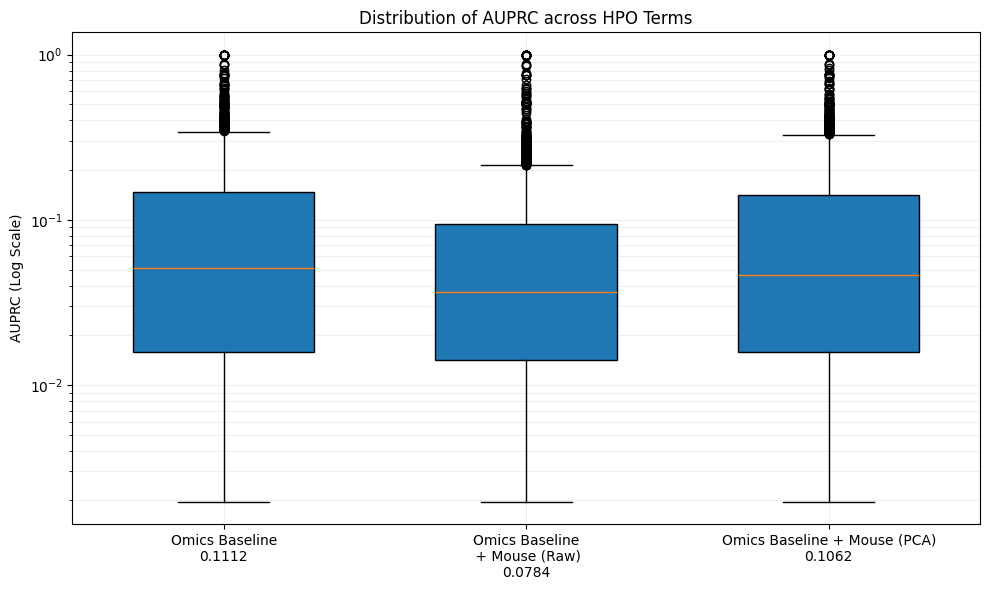

In [69]:
data_to_plot = [valid_scores, aug_scores, aug_scores_smart]
labels = [f'Omics Baseline\n{np.mean(valid_scores):.4f}', f'Omics Baseline\n + Mouse (Raw)\n{np.mean(aug_scores):.4f}', f'Omics Baseline + Mouse (PCA)\n{np.mean(aug_scores_smart):.4f}']

mean_auprc_box_plot(data_to_plot, labels)


OMICS vs Borzoi vs ESM C (300)

/tmp/ipython-input-1385720561.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot(data, positions=range(1, len(data) + 1), widths=0.6, patch_artist=True, labels=labels)


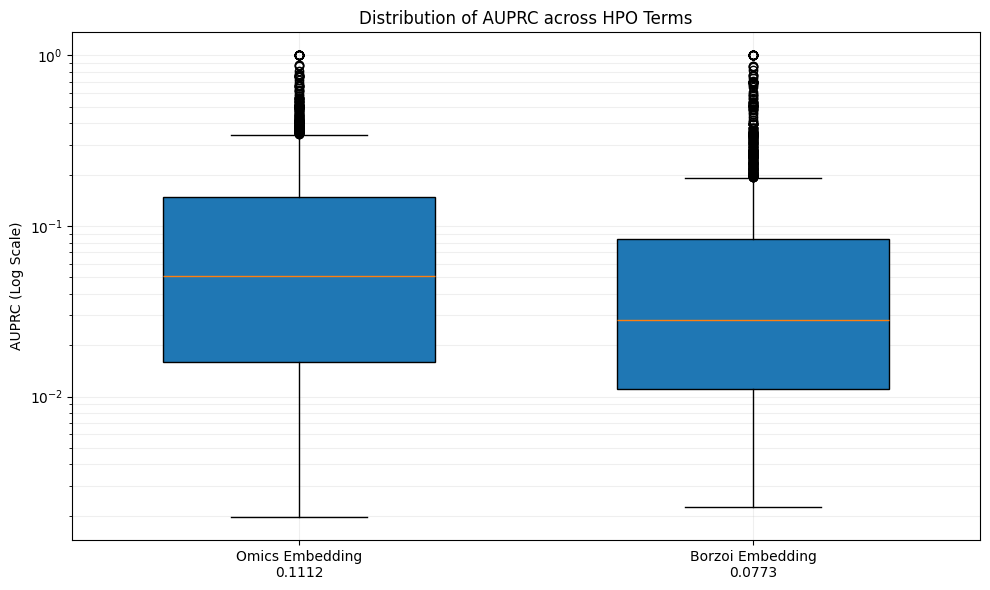

In [71]:
data_to_plot = [valid_scores, scores_results_borzoi]
labels = [f'Omics Embedding\n{np.mean(valid_scores):.4f}', f'Borzoi Embedding\n{np.mean(scores_results_borzoi):.4f}']

mean_auprc_box_plot(data_to_plot, labels)

### Neural Network

/tmp/ipython-input-1385720561.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bplot = plt.boxplot(data, positions=range(1, len(data) + 1), widths=0.6, patch_artist=True, labels=labels)


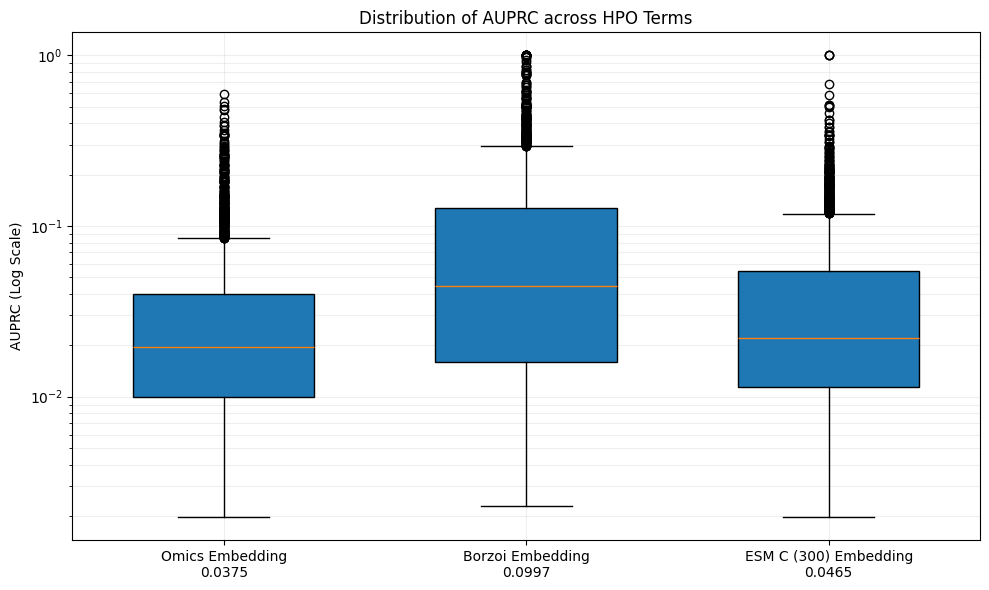

In [72]:
data_to_plot = [omics_nn_scores, borzoi_nn_scores, esmc_300_nn_scores]
labels = [f'Omics Embedding\n{np.mean(omics_nn_scores):.4f}', f'Borzoi Embedding\n{np.mean(borzoi_nn_scores):.4f}', f'ESM C (300) Embedding\n{np.mean(esmc_300_nn_scores):.4f}']

mean_auprc_box_plot(data_to_plot, labels)